# Nonparametric Comparison of Toxin–Organelle Colocalization Coefficients Using Violin Plots

This notebook analyzes the `m1` and `m2` coefficients from toxin-organelle colocalization experiments across different experimental conditions.

## Workflow

### Data Preparation
- `m1` and `m2` values are extracted from input tables and organized by condition.

### Statistical Analysis
- The **Kruskal–Wallis H-test** is applied to evaluate global differences among groups.
- If significant, **Dunn’s multiple comparisons test** with **Bonferroni correction** is used for post hoc pairwise comparisons.

### Results Reporting
- Kruskal–Wallis statistics and p-values are reported.
- Dunn’s test provides adjusted p-values for each pair of conditions.

### Visualization
- **Violin plots** are used to represent the distribution of `m1` and `m2` values across conditions.


## Install libraries

In [1]:
print("Installing necessary libraries...")
!pip install scikit-posthocs > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import scikit_posthocs as sp
import textwrap
from matplotlib.backends.backend_pdf import PdfPages

## Define the working directory 

In [3]:
wd = '/home/jovyan/LNMA/bravoa/data/'

## Global parameters

In [4]:
max_conditions = 5
violin_fontsize = 8
stat_fontsize = 10
stat_figsize = (14, 11)
line_width = 160

## Data configurations

In [5]:
# Define data configurations
data_configurations = {
    "Toxin_vs_actin": {"df_name": "Toxin_vs_actin"},
    "Toxin_vs_Nucleus_a": {"df_name": "Toxin_vs_Nucleus_a"},
    "Toxin_vs_actin_ord": {"df_name": "Toxin_vs_actin_ord"},
    "Toxin_vs_actin_desord": {"df_name": "Toxin_vs_actin_desord"},
    "Toxin_vs_actin_mutord": {"df_name": "Toxin_vs_actin_mutord"},
    "Toxin_vs_Nucleus_ER": {"df_name": "Toxin_vs_Nucleus_ER"},
    "Toxin_vs_ER": {"df_name": "Toxin_vs_ER"},
    "Toxin_vs_Nucleus_L": {"df_name": "Toxin_vs_Nucleus_L"},
    "Toxin_vs_Lizo": {"df_name": "Toxin_vs_Lizo"},
    "Toxin_vs_Nucleus_M": {"df_name": "Toxin_vs_Nucleus_M"},
    "Toxin_vs_Mito": {"df_name": "Toxin_vs_Mito"},
    "Toxin_vs_Nucleus_E": {"df_name": "Toxin_vs_Nucleus_E"},
    "Toxin_vs_Endo": {"df_name": "Toxin_vs_Endo"},
    "Toxin_vs_EndoEarly": {"df_name": "Toxin_vs_EndoEarly"},
    "Toxin_vs_mutEndoEarly": {"df_name": "Toxin_vs_mutEndoEarly"},
    "Vesicles_Toxin_vs_actin": {"df_name": "Vesicles_Toxin_vs_actin"},
    "Vesicles_Toxin_vs_ER": {"df_name": "Vesicles_Toxin_vs_ER"},
    "Vesicles_Toxin_vs_Lizo": {"df_name": "Vesicles_Toxin_vs_Lizo"},
    "Vesicles_Toxin_vs_Mito": {"df_name": "Vesicles_Toxin_vs_Mito"},
    "Vesicles_Toxin_vs_Endo": {"df_name": "Vesicles_Toxin_vs_Endo"}
}

# Configurations for the categories
vesicles_configurations = {
    "actin": data_configurations["Vesicles_Toxin_vs_actin"],
    "ER": data_configurations["Vesicles_Toxin_vs_ER"],
    "lysosomes": data_configurations["Vesicles_Toxin_vs_Lizo"],
    "mitochondria": data_configurations["Vesicles_Toxin_vs_Mito"],
    "endosomes": data_configurations["Vesicles_Toxin_vs_Endo"]
}

nucleus_configurations = {
    "actin": data_configurations["Toxin_vs_Nucleus_a"],
    "ER": data_configurations["Toxin_vs_Nucleus_ER"],
    "lysosomes": data_configurations["Toxin_vs_Nucleus_L"],
    "mitochondria": data_configurations["Toxin_vs_Nucleus_M"],
    "endosomes": data_configurations["Toxin_vs_Nucleus_E"]
}

cytoplasm_configurations = {
    "actin": data_configurations["Toxin_vs_actin"],
    "ER": data_configurations["Toxin_vs_ER"],
    "lysosomes": data_configurations["Toxin_vs_Lizo"],
    "mitochondria": data_configurations["Toxin_vs_Mito"],
    "endosomes": data_configurations["Toxin_vs_Endo"]
}

actin_configurations = {
    "Cry11Aa-polymerized Actin": data_configurations["Toxin_vs_actin_ord"],
    "Cry11Aa-depolymerized": data_configurations["Toxin_vs_actin_desord"],
    "Cry11AaE97A-polymerized Actin": data_configurations["Toxin_vs_actin_mutord"]
}

endo_configurations = {
    "Cry11Aa": data_configurations["Toxin_vs_EndoEarly"],
    "Cry11AaE97A": data_configurations["Toxin_vs_mutEndoEarly"]
}


## Custom labels for specific categories
actin_labels = ["Cry11Aa-polymerized Actin", "Cry11Aa-depolymerized actin", "Cry11AaE97A-polymerized Actin"]
endo_labels = ["Cry11Aa", "Cry11AaE97A"]


## Define Functions

In [6]:
def compute_data_for_category(configurations, category_name, max_conditions, custom_labels=None):
    """
    Computes data_M1, data_M2, and conditions for the given category.

    Parameters:
    - configurations: Dictionary with configuration details.
    - category_name: The category name for which data is being computed.
    - max_conditions: Maximum number of conditions to include.
    - custom_labels: Optional custom labels for the conditions.

    Returns:
    - data_M1: List of M1 data arrays.
    - data_M2: List of M2 data arrays.
    - conditions: List of conditions labels.
    """
    data_M1 = []
    data_M2 = []
    conditions = []

    # Load data for each configuration in the category
    for config_name, config in configurations.items():
        file_path = os.path.join(wd, f"{config['df_name']}_all_manders_results.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            if 'm1' in df.columns and 'm2' in df.columns:
                data_M1.append(df['m1'].tolist())
                data_M2.append(df['m2'].tolist())
                conditions.append(config_name)
        else:
            print(f"File not found: {file_path}")

    # If custom_labels are provided, pad data to match lengths
    if custom_labels:
        while len(data_M1) < len(custom_labels):
            data_M1.append([])
            data_M2.append([])
        conditions = custom_labels

    # Add empty labels and data to standardize heights
    while len(conditions) < max_conditions:
        conditions.append("")
        data_M1.append([])
        data_M2.append([])

    return data_M1, data_M2, conditions

def plot_single_category_violin(ax, data_M1, data_M2, conditions, category_name, max_conditions):
    """
    Plots M1 and M2 violin plots for the given category data.

    Parameters:
    - ax: Array of Axes objects for plotting.
    - data_M1: List of M1 data arrays.
    - data_M2: List of M2 data arrays.
    - conditions: List of condition labels.
    - category_name: The category name for the plots.
    - max_conditions: Maximum number of conditions to display.
    """
    positions = range(1, len(conditions) + 1)

    # Filter out empty datasets
    valid_data_M1 = [data for data in data_M1 if len(data) > 0]
    valid_data_M2 = [data for data in data_M2 if len(data) > 0]
    valid_conditions_M1 = [conditions[i] for i in range(len(data_M1)) if len(data_M1[i]) > 0]
    valid_conditions_M2 = [conditions[i] for i in range(len(data_M2)) if len(data_M2[i]) > 0]

    # Violin plot for M1
    ax[0].violinplot(valid_data_M1, positions=range(1, len(valid_conditions_M1) + 1), 
                     vert=False, widths=0.8, showmeans=True, showextrema=True, showmedians=True)
    ax[0].set_title(f"{category_name} M1")
    ax[0].set_xlim(0.2, 1)
    ax[0].set_ylim(0.5, max_conditions + 0.5)
    ax[0].set_yticks(range(1, len(valid_conditions_M1) + 1))
    ax[0].set_yticklabels(valid_conditions_M1)
    for i, data in enumerate(valid_data_M1):
        ax[0].text(0.9, i + 1, f'n={len(data)}', va='center', fontsize=violin_fontsize)

    # Violin plot for M2
    ax[1].violinplot(valid_data_M2, positions=range(1, len(valid_conditions_M2) + 1), 
                     vert=False, widths=0.8, showmeans=True, showextrema=True, showmedians=True)
    ax[1].set_title(f"{category_name} M2")
    ax[1].set_xlim(0.2, 1)
    ax[1].set_ylim(0.5, max_conditions + 0.5)
    ax[1].set_yticks(range(1, len(valid_conditions_M2) + 1))
    ax[1].set_yticklabels("")
    for i, data in enumerate(valid_data_M2):
        ax[1].text(0.9, i + 1, f'n={len(data)}', va='center', fontsize=violin_fontsize)


#############

def perform_statistical_analysis(data_df, value_col, condition_col):
    '''
    Performs Kruskal-Wallis H-test and Dunn’s multiple comparisons test with Bonferroni correction.

    Parameters:
    - data_df (pd.DataFrame): DataFrame containing the data.
    - value_col (str): Column name for the numeric values.
    - condition_col (str): Column name for the condition labels.

    Returns:
    - dict: Contains Kruskal-Wallis results and Dunn's test matrix.
    '''
    grouped_data = [group[value_col].tolist() for _, group in data_df.groupby(condition_col)]
    kruskal_stat, kruskal_p = stats.kruskal(*grouped_data)
    dunn_result = sp.posthoc_dunn(data_df, val_col=value_col, group_col=condition_col, p_adjust='bonferroni')

    return {
        "kruskal_wallis": {
            "statistic": kruskal_stat,
            "p_value": kruskal_p,
        },
        "dunn_test": dunn_result
    }

def analyze_all_datasets():
    """
    Runs Kruskal-Wallis and Dunn’s test on all defined datasets.
    Assumes these variables are already loaded: data_vesicles_M1, data_nucleus_M1, etc.
    """
    datasets = {
        "Extracellular Vesicles M1": (data_vesicles_M1, conditions_vesicles),
        "Extracellular Vesicles M2": (data_vesicles_M2, conditions_vesicles),
        "Nucleus M1": (data_nucleus_M1, conditions_nucleus),
        "Nucleus M2": (data_nucleus_M2, conditions_nucleus),
        "Cytoplasm M1": (data_cytoplasm_M1, conditions_cytoplasm),
        "Cytoplasm M2": (data_cytoplasm_M2, conditions_cytoplasm),
        "Microvilli M1": (data_actin_M1, conditions_actin),
        "Microvilli M2": (data_actin_M2, conditions_actin),
        "Endosomes M1": (data_endo_M1, conditions_endo),
        "Endosomes M2": (data_endo_M2, conditions_endo),
    }

    def prepare_dataframe(data, conditions):
        data_flat = []
        labels = []
        for i, values in enumerate(data):
            data_flat.extend(values)
            labels.extend([conditions[i]] * len(values))
        return pd.DataFrame({"Value": data_flat, "Condition": labels})

    results = {}
    for name, (data, conds) in datasets.items():
        print(f"Analyzing {name}...")
        df = prepare_dataframe(data, conds)
        res = perform_statistical_analysis(df, "Value", "Condition")
        results[name] = res
        print(f"Kruskal-Wallis: {res['kruskal_wallis']}")
        print("Dunn’s test (Bonferroni corrected):")
        print(res['dunn_test'])
        print("\n" + "-"*80 + "\n")

    return results

def summarize_significant_dunn_tests(all_results, alpha=0.05):
    """
    Generates a text summary of significant results from Dunn's test.

    Parameters:
    - all_results: Dictionary of statistical analysis results per dataset.
    - alpha: Significance level (default = 0.05).

    Returns:
    - Dictionary mapping dataset names to textual summaries.
    """
    summaries = {}

    for dataset_name, result in all_results.items():
        dunn_table = result["dunn_test"]
        significant = []

        for row in dunn_table.index:
            for col in dunn_table.columns:
                if row != col and dunn_table.loc[row, col] < alpha:
                    pair = tuple(sorted([row, col]))
                    if pair not in significant:
                        significant.append(pair)

        if significant:
            pairs_str = "; ".join([f"{a} vs {b}" for a, b in significant])
            text = f"In '{dataset_name}', significant differences (p < {alpha}) were found between: {pairs_str}."
        else:
            text = f"In '{dataset_name}', no significant pairwise differences were found (p < {alpha})."

        summaries[dataset_name] = text

    return summaries


# Prepare and wrap the text content for saving stats
def prepare_statistics_text_wrapped(all_results, summaries, line_width=line_width):
    lines = []
    for dataset_name, result in all_results.items():
        lines.append(f"Dataset: {dataset_name}")
        lines.append(f"Kruskal-Wallis Test:")
        lines.append(f"  Statistic = {result['kruskal_wallis']['statistic']:.4f}")
        lines.append(f"  p-value = {result['kruskal_wallis']['p_value']:.4e}")
        lines.append("")
        lines.append("Dunn’s Multiple Comparisons Test (Bonferroni corrected):")
        dunn_lines = result['dunn_test'].to_string(float_format="%.3e").split("\n")
        for line in dunn_lines:
            lines.extend(textwrap.wrap(line, width=line_width))
        lines.append("")
        lines.append("Summary of Significant Differences:")
        lines.extend(textwrap.wrap(summaries[dataset_name], width=line_width))
        lines.append("-" * line_width)
        lines.append("")
    return lines


## Prepare data

In [7]:
# Compute data for each category
data_vesicles_M1, data_vesicles_M2, conditions_vesicles = compute_data_for_category(
    vesicles_configurations, "Extracellular Vesicles", max_conditions
)
data_nucleus_M1, data_nucleus_M2, conditions_nucleus = compute_data_for_category(
    nucleus_configurations, "Nucleus", max_conditions
)
data_cytoplasm_M1, data_cytoplasm_M2, conditions_cytoplasm = compute_data_for_category(
    cytoplasm_configurations, "Cytoplasm", max_conditions
)
data_actin_M1, data_actin_M2, conditions_actin = compute_data_for_category(
    actin_configurations, "Microvilli", max_conditions, custom_labels=actin_labels
)
data_endo_M1, data_endo_M2, conditions_endo = compute_data_for_category(
    endo_configurations, "Endosomes", max_conditions, custom_labels=endo_labels
)


## Plot data

Saved combined plot as PDF: /home/jovyan/LNMA/bravoa/data/Manders_Coefficients_All_Categories_Violin.pdf


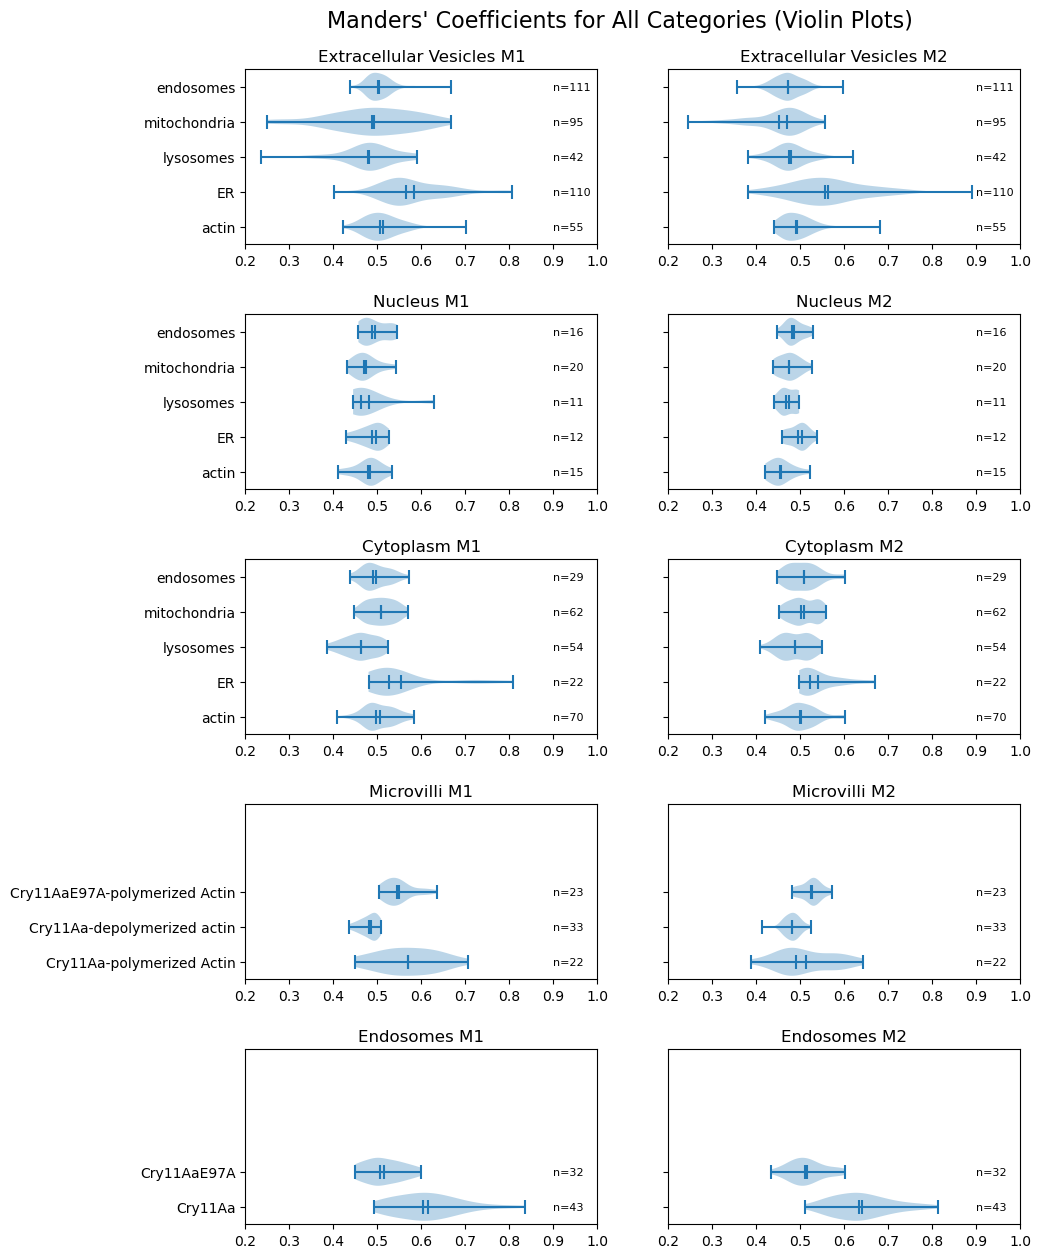

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))  # Adjusted size for 5 categories
plt.subplots_adjust(hspace=0.4)

plot_single_category_violin(axes[0], data_vesicles_M1, data_vesicles_M2, conditions_vesicles, "Extracellular Vesicles", max_conditions)
plot_single_category_violin(axes[1], data_nucleus_M1, data_nucleus_M2, conditions_nucleus, "Nucleus", max_conditions)
plot_single_category_violin(axes[2], data_cytoplasm_M1, data_cytoplasm_M2, conditions_cytoplasm, "Cytoplasm", max_conditions)
plot_single_category_violin(axes[3], data_actin_M1, data_actin_M2, conditions_actin, "Microvilli", max_conditions)
plot_single_category_violin(axes[4], data_endo_M1, data_endo_M2, conditions_endo, "Endosomes", max_conditions)

pdf_plot_path = os.path.join(wd, "Manders_Coefficients_All_Categories_Violin.pdf")
fig.suptitle("Manders' Coefficients for All Categories (Violin Plots)", fontsize=16, y=0.92)
plt.savefig(pdf_plot_path, format="pdf")
print(f"Saved combined plot as PDF: {pdf_plot_path}")

plt.show()

## Perform statistical comparisions for all datasets using Kruskal–Wallis followed by Dunn’s test with Bonferroni correction

In [9]:
all_results = analyze_all_datasets()

Analyzing Extracellular Vesicles M1...
Kruskal-Wallis: {'statistic': 114.17239855183716, 'p_value': 9.372417409664089e-24}
Dunn’s test (Bonferroni corrected):
                        ER         actin     endosomes     lysosomes  \
ER            1.000000e+00  1.167694e-08  2.875967e-16  1.062007e-14   
actin         1.167694e-08  1.000000e+00  1.000000e+00  2.817281e-01   
endosomes     2.875967e-16  1.000000e+00  1.000000e+00  7.959367e-01   
lysosomes     1.062007e-14  2.817281e-01  7.959367e-01  1.000000e+00   
mitochondria  1.554779e-15  1.000000e+00  1.000000e+00  1.000000e+00   

              mitochondria  
ER            1.554779e-15  
actin         1.000000e+00  
endosomes     1.000000e+00  
lysosomes     1.000000e+00  
mitochondria  1.000000e+00  

--------------------------------------------------------------------------------

Analyzing Extracellular Vesicles M2...
Kruskal-Wallis: {'statistic': 122.41730624148818, 'p_value': 1.6265615559626186e-25}
Dunn’s test (Bonferroni cor

In [10]:
summaries = summarize_significant_dunn_tests(all_results)
for name, summary in summaries.items():
    print(summary)

In 'Extracellular Vesicles M1', significant differences (p < 0.05) were found between: ER vs actin; ER vs endosomes; ER vs lysosomes; ER vs mitochondria.
In 'Extracellular Vesicles M2', significant differences (p < 0.05) were found between: ER vs actin; ER vs endosomes; ER vs lysosomes; ER vs mitochondria; actin vs mitochondria.
In 'Nucleus M1', no significant pairwise differences were found (p < 0.05).
In 'Nucleus M2', significant differences (p < 0.05) were found between: ER vs actin; actin vs endosomes.
In 'Cytoplasm M1', significant differences (p < 0.05) were found between: ER vs endosomes; ER vs lysosomes; actin vs lysosomes; endosomes vs lysosomes; lysosomes vs mitochondria.
In 'Cytoplasm M2', significant differences (p < 0.05) were found between: ER vs actin; ER vs lysosomes.
In 'Microvilli M1', significant differences (p < 0.05) were found between: Cry11Aa-depolymerized actin vs Cry11Aa-polymerized Actin; Cry11Aa-depolymerized actin vs Cry11AaE97A-polymerized Actin.
In 'Microv

In [11]:
# Define the output PDF path
pdf_stats_path = os.path.join(wd, "Manders_Coefficients_All_Categories_Stats.pdf")

# Generate the wrapped lines
statistics_text = prepare_statistics_text_wrapped(all_results, summaries)

# Save text to PDF
with PdfPages(pdf_stats_path) as pdf:
    max_lines_per_page = 40
    for i in range(0, len(statistics_text), max_lines_per_page):
        fig, ax = plt.subplots(figsize=stat_figsize)  # Wide landscape format
        ax.axis('off')
        chunk = statistics_text[i:i + max_lines_per_page]
        text = "\n".join(chunk)
        ax.text(0.01, 0.99, text, va='top', ha='left',
                fontsize=stat_fontsize, family='monospace', wrap=True)
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved: {pdf_stats_path}")


PDF saved: /home/jovyan/LNMA/bravoa/data/Manders_Coefficients_All_Categories_Stats.pdf
